In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-01 14:42:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: 'AER_credit_card_data.csv'

     0K .......... .......... .......... .......... .......... 69% 1.36M 0s
    50K .......... .......... .                               100% 17.1M=0.04s

2022-10-01 14:42:21 (1.88 MB/s) - 'AER_credit_card_data.csv' saved [73250/73250]



In [2]:
df = pd.read_csv('AER_credit_card_data.csv')

df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.


In [3]:
df.card = (df.card == 'yes').astype('int')

df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [6]:
y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

In [7]:
len(df_train), len(df_val), len(df_test), len(y_train), len(y_val), len(y_test)

(791, 264, 264, 791, 264, 264)

In [8]:
df.dtypes

card             int32
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC? **share**

- reports
- dependents
- active
- share


In [9]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [10]:
numeric = [
    'reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active'
]

scores_auc = {}

for col in numeric:
    auc_card = roc_auc_score(y_train, df_train[col])
    scores_auc[col] = auc_card if auc_card >= 0.5 else roc_auc_score(y_train, -df_train[col])
    
dict(sorted(scores_auc.items(), key=lambda item: item[1]))

{'age': 0.5240020979407055,
 'months': 0.5294217780967629,
 'dependents': 0.5327757227773791,
 'majorcards': 0.5343859842838476,
 'income': 0.5908049467233478,
 'active': 0.6043173411362006,
 'reports': 0.7166629860689376,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873}

## Training the model

From now on, use these columns only:

    ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [11]:
features = [
    "reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"
]

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
train_dict = df_train[features].to_dict(orient = 'records')
val_dict = df_val[features].to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [14]:
print(X_train.shape)

print(dv.get_feature_names_out())

(791, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']


In [15]:
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 1)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [16]:
print(model.intercept_[0].round(3))
print(model.coef_[0].round(3))

-0.632
[ 1.090e-01 -8.000e-03 -9.550e-01  1.569e+00 -3.000e-02  2.300e-02
 -1.000e-03 -4.420e-01 -1.910e-01 -1.400e+00 -5.230e-01 -1.090e-01
 -0.000e+00]


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

**0.995**


In [17]:
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]


print(round(roc_auc_score(y_val, y_pred_proba),3))

0.995


## Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect? **0.3**

- 0.1
- 0.3
- 0.6
- 0.8


In [18]:
thresholds = np.linspace(0.0, 1.0, 101)

scores_thr = []

actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

for t in thresholds:
    
    predicted_pos = (y_pred_proba >= t)
    predicted_neg = (y_pred_proba < t)
    
    tp = (predicted_pos & actual_pos).sum()
    tn = (predicted_neg & actual_neg).sum()
    fp = (predicted_pos & actual_neg).sum()
    fn = (predicted_neg & actual_pos).sum()
    
    scores_thr.append((t, tp, tn, fp, fn))
    
cols = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores_thr = pd.DataFrame(scores_thr, columns = cols)

In [19]:
df_scores_thr['precision'] = (df_scores_thr['tp'])/(df_scores_thr['tp'] + df_scores_thr['fp'])
df_scores_thr['recall'] = (df_scores_thr['tp'])/(df_scores_thr['tp'] + df_scores_thr['fn'])

df_scores_thr.head()

,threshold,tp,tn,fp,fn,precision,recall
0,0.00,211,0,53,0,0.799242,1.0
1,0.01,211,19,34,0,0.861224,1.0
2,0.02,211,22,31,0,0.871901,1.0
3,0.03,211,29,24,0,0.897872,1.0
4,0.04,211,31,22,0,0.905579,1.0


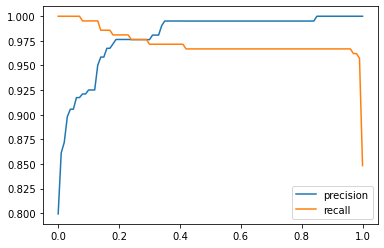

In [20]:
plt.plot(df_scores_thr['threshold'], df_scores_thr['precision'], label = 'precision')
plt.plot(df_scores_thr['threshold'], df_scores_thr['recall'], label = 'recall')

plt.legend()

In [21]:
df_scores_thr.loc[df_scores_thr['recall'] == df_scores_thr['precision']]

,threshold,tp,tn,fp,fn,precision,recall
24,0.24,206,48,5,5,0.976303,0.976303
25,0.25,206,48,5,5,0.976303,0.976303
26,0.26,206,48,5,5,0.976303,0.976303
27,0.27,206,48,5,5,0.976303,0.976303
28,0.28,206,48,5,5,0.976303,0.976303
29,0.29,206,48,5,5,0.976303,0.976303


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal? **0.4**

- 0.1
- 0.4
- 0.6
- 0.7


In [22]:
df_scores_thr['f1'] = (2 * df_scores_thr['precision'] * df_scores_thr['recall']) \
                        / (df_scores_thr['precision'] + df_scores_thr['recall'])

In [31]:
df_scores_thr.sort_values(by = ['f1'], ascending = False).head(15)

,threshold,tp,tn,fp,fn,precision,recall,f1
39,0.39,205,52,1,6,0.995146,0.971564,0.983213
38,0.38,205,52,1,6,0.995146,0.971564,0.983213
37,0.37,205,52,1,6,0.995146,0.971564,0.983213
36,0.36,205,52,1,6,0.995146,0.971564,0.983213
35,0.35,205,52,1,6,0.995146,0.971564,0.983213
41,0.41,205,52,1,6,0.995146,0.971564,0.983213
40,0.40,205,52,1,6,0.995146,0.971564,0.983213
88,0.88,204,53,0,7,1.000000,0.966825,0.983133
85,0.85,204,53,0,7,1.000000,0.966825,0.983133
86,0.86,204,53,0,7,1.000000,0.966825,0.983133


## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds? **0.003**

- 0.003
- 0.014
- 0.09
- 0.24


In [24]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [25]:
df_full_train.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13


In [26]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

scores_cv = []
step = 0

for train_idx, val_idx in kfold.split(df_full_train):
    
    #split the data
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['card'].values
    y_val = df_val['card'].values
    
    #train the model 
    train_dict = df_train[features].to_dict(orient = 'records')
    val_dict = df_val[features].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)

    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    
    print(step)
    print(X_train.shape)
    print(dv.get_feature_names_out())
    
    model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 1) #rand remove?
    model.fit(X_train, y_train)
    
    #predict 
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    print('AUC: ', auc_score, '\n')
    step += 1
    
    scores_cv.append(auc_score)


0
(844, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']
AUC:  0.9941860465116279 

1
(844, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']
AUC:  0.9941176470588236 

2
(844, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']
AUC:  0.9943346508563901 

3
(844, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']
AUC:  0.9996107939802803 

4
(844, 13)
['active' 'age' 'dependents' 'expenditure' 'income' 'majorcards' 'months'
 'owner=no' 'owner=yes' 'reports' 'selfemp=no' 'selfemp=yes' 'share']
AUC:  1.0 



In [27]:
print('%.3f +- %.3f' % (np.mean(scores_cv), np.std(scores_cv)))

0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score? **1**

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C


In [34]:
for C in tqdm([0.01, 0.1, 1, 10]):
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

    scores_cv = []
    step = 0
    
    print('C: ', C)

    for train_idx, val_idx in kfold.split(df_full_train):
    
        #split the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train['card'].values
        y_val = df_val['card'].values
        
        #train the model 
        train_dict = df_train[features].to_dict(orient = 'records')
        val_dict = df_val[features].to_dict(orient = 'records')
        
        dv = DictVectorizer(sparse = False)
        
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
    
        #print(step)
        #print(X_train.shape)
        #print(dv.get_feature_names_out())
    
        model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000, random_state = 1) #rand remove?
        model.fit(X_train, y_train)
    
        #predict 
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        print('AUC: ', auc_score, '\n')
        step += 1
    
        scores_cv.append(auc_score)
        
    print('mean - std : %.3f +- %.3f' % (np.mean(scores_cv), np.std(scores_cv)))
    print('\n\n')


  0%|          | 0/4 [00:00<?, ?it/s]

C:  0.01
AUC:  0.98421926910299 

AUC:  0.9875 

AUC:  0.9922266139657444 

AUC:  0.9954592631032693 

AUC:  1.0 

mean - std : 0.992 +- 0.006



C:  0.1
AUC:  0.9900332225913621 

AUC:  0.991421568627451 

AUC:  0.9948616600790514 

AUC:  0.9989621172807472 

AUC:  1.0 

mean - std : 0.995 +- 0.004



C:  1
AUC:  0.9941860465116279 

AUC:  0.9941176470588236 

AUC:  0.9943346508563901 

AUC:  0.9996107939802803 

AUC:  1.0 

mean - std : 0.996 +- 0.003



C:  10
AUC:  0.9934939091915835 

AUC:  0.9942401960784313 

AUC:  0.9945981554677206 

AUC:  0.9996107939802803 

AUC:  1.0 

mean - std : 0.996 +- 0.003



